In [1]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 10.7 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl s

In [2]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

--2024-03-06 13:07:50--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  32.2MB/s    in 1.9s    

2024-03-06 13:07:52 (32.2 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [3]:
!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

In [3]:
import gradio as gr
import cv2
import tensorflow as tf
from keras.models import load_model
import numpy as np
from google.colab.patches import cv2_imshow
import os
import dlib

In [4]:

vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)


In [ ]:
model.summary()

In [7]:
cropping_dictionary = {}
cropping_dictionary['s30'] = (200,246,80,220)
cropping_dictionary['s5'] = (210,256,120,260)
cropping_dictionary['s20'] = (200,246,120,260)
cropping_dictionary['s1'] = (190,236,80,220)

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss
tf.keras.utils.get_custom_objects()['CTCLoss'] = CTCLoss
model= load_model('/content/drive/MyDrive/LipNetModel/Lipnet_grid_dataset.h5', custom_objects={'CTCLoss': CTCLoss})
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [8]:
model.inputs

[<KerasTensor: shape=(None, 75, 46, 140, 1) dtype=float32 (created by layer 'conv3d_input')>]

In [9]:
def detect_box(lips):
    minX = 10**9
    minY = 10**9
    maxX = 0
    maxY = 0
    for x,y in lips:
      minX = min(minX,x)
      maxX = max(maxX,x)
      minY = min(minY,y)
      maxY = max(maxY,y)
    # print((minX,minY),(maxX,maxY))
    return minX,minY,maxX,maxY

def crop_image(minX,minY,maxX,maxY,image):
  height = maxY-minY
  width = maxX-minX
  # print(minX,minY,maxX,maxY)
  if height>46 or width>140:
    image = cv2.resize(image[minY:maxY,minX:maxX,:],(140,46))
    return image
  else:
    diffY = 46-height
    diffX = 140-width
    # print(diffY,diffX)
    # print(minY-diffY//2 - diffY%2 , maxY+diffY//2,minX - diffX//2 -diffX %2 , maxX + diffX//2)
    return image[minY-diffY//2 - diffY%2 : maxY+diffY//2,minX - diffX//2 -diffX %2 : maxX + diffX//2,:]
def detect_lips(image_path):
    predictor_path = '/content/shape_predictor_68_face_landmarks.dat'
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)

    # gray = cv2.imread(image_path)
    gray = image_path
    # print(image.shape)
    # gray = cv2.cvtColor(gray,cv2.COLOR_BGR2GRAY)
    print(gray.shape)
    try:
      faces = detector(gray)
      for face in faces:
        landmarks = predictor(gray,face)
        lips = [(landmarks.part(i).x ,landmarks.part(i).y) for i in range(48,68)]

      minX,minY,maxX,maxY = detect_box(lips)

      height = maxY-minY
      width = maxX-minX
      if height>46 or width>140:
        return
      diffY = 46-height
      diffX = 140-width
      minY = minY-diffY//2 - diffY%2
      maxY = maxY+diffY//2
      minX = minX - diffX//2 -diffX %2
      maxX = maxX + diffX//2
      cropped_image = (minX,minY,maxX,maxY)
      # print(cropped_image,maxY-minY,maxX-minX)
      # cv2_imshow(gray[minY:maxY,minX:maxX])
      # cropped_image = crop_image(minX,minY,maxX,maxY,gray)
      return cropped_image
    except Exception as e:
      print(e)
      return gray

In [10]:
detect_lips(cv2.imread('/content/download (1).jpeg'))

AttributeError: 'NoneType' object has no attribute 'shape'

In [71]:
182-42,136-90
220-80,236-190
b,d,a,c

(140, 46)

In [33]:
cropping_dictionary['s1']   a,b,c,d

(190, 236, 80, 220)

In [11]:
def predict(video):
    cap = cv2.VideoCapture(video)
    ret, frame = cap.read()
    cv2_imshow(frame)
    b,d,a,c = detect_lips(frame)
    print(d,c,b,a)
    frames = []
    cap = cv2.VideoCapture(video)
    for _ in range(min(75,int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[d:c,b:a,:])
    cv2_imshow(np.array(frame[d:c,b:a,:]))
    # print(np.array(frames).shape)
    cap.release()
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    frames = tf.cast((frames - mean), tf.float32) / std
    frames = tf.expand_dims(frames,axis = 0)
    yhat = model.predict(frames)
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
    output= [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
    print('output',output)
    return output[0].numpy()

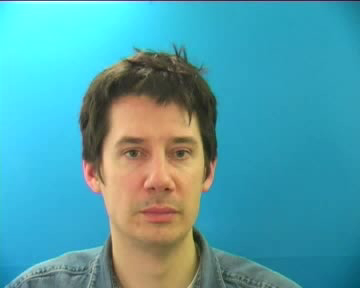

(288, 360, 3)
190 236 89 229


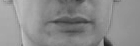

1/1 [==============================] - 3s 3s/step
output [<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue it two please'>]


b'lay blue it two please'

In [13]:
predict('/content/bbil4p.mpg')

In [37]:
!ls

'download (1).jpeg'   drive     sample_data
 download.jpeg	      flagged   shape_predictor_68_face_landmarks.dat


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://e6760c0eb246fbc095.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


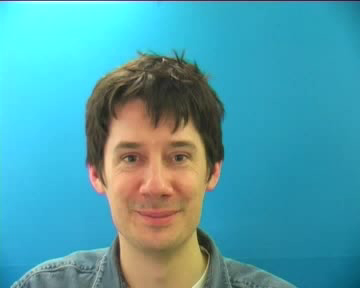

(288, 360, 3)
193 239 87 227


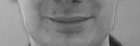

1/1 [==============================] - 3s 3s/step
output [<tf.Tensor: shape=(), dtype=string, numpy=b'bln greed in v ti pleain'>]
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e6760c0eb246fbc095.gradio.live


In [14]:
interface = gr.Interface(
  fn=predict,
  inputs=gr.Video(),
  outputs=gr.Text(),
  title="Video Processing",
  description="Upload a video or use your webcam for processing."
)

interface.launch(debug = True)
